## Imports

In [1]:
import pandas as pd 
from glob import glob
from pathlib import Path
from os import path
import numpy
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import pprint

from scipy.stats import zscore
from sklearn.decomposition import PCA

%matplotlib inline
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

# Paths / Files

In [2]:
OAK = '/Users/henrymj/Documents/mounts/OAK' # CHANGE
BIDS_dir = path.join(OAK, 'data','uh2','aim1', 'BIDS_scans')

In [3]:
tasks = ['ANT', 'discountFix', 'DPX', 'motorSelectiveStop', 'stopSignal', \
         'twoByTwo', 'stroop', 'WATT', 'CCTHot']

In [4]:
file_dict = {} #dict for storing task event file data 
for task in tasks: 
    file_dict[task] = glob(path.join(BIDS_dir, 'sub-s*', 'ses-*', 'func', f'*{task}*_events.tsv'))

# Helper Functions

In [5]:
def ezdiff(rt,correct,s=1.0):
    logit = lambda p:numpy.log(p/(1-p))

    assert len(rt)>0
    assert len(rt)==len(correct)
    
    assert numpy.max(correct)<=1
    assert numpy.min(correct)>=0
    
    pc=numpy.mean(correct)

    assert pc > 0
    
    # subtract or add 1/2 an error to prevent division by zero
    if pc==1.0:
        pc=1 - 1/(2*len(correct))
    if pc==0.5:
        pc=0.5 + 1/(2*len(correct))
    MRT=numpy.mean(rt[correct==1])
    VRT=numpy.var(rt[correct==1])

    assert VRT > 0
    
    r=(logit(pc)*(((pc**2) * logit(pc)) - pc*logit(pc) + pc - 0.5))/VRT
    v=numpy.sign(pc-0.5)*s*(r)**0.25
    a=(s**2 * logit(pc))/v
    y=(-1*v*a)/(s**2)
    MDT=(a/(2*v))*((1-numpy.exp(y))/(1+numpy.exp(y)))
    t=MRT-MDT
    
    return([a,v,t])

In [6]:
def rt_qa(data_df, short_thresh = .2, long_thresh = 2.5): 
    """
    quick and dirty alerts for problematic data
    negative reaction times
    long reaction times 
    short reaction times
    """
    rt_dict = {'negative_rts': {},
              'short_rts': {},
              'long_rts': {}}
    for sub in data_df['worker_id'].unique(): 
        sub_df = data_df.loc[data_df['worker_id'] == sub]
        rt_dict['negative_rts'][sub] = len(sub_df.loc[sub_df['response_time'] < 0])
        rt_dict['short_rts'][sub] = len(sub_df.loc[sub_df['response_time'] < short_thresh])
        rt_dict['long_rts'][sub] = len(sub_df.loc[sub_df['response_time'] > long_thresh])
    return rt_dict

def junk_qa(data_df): 
    """
    calc number of junk trials 
    """
    junk_dict = {} 
    for sub in data_df['worker_id'].unique(): 
        sub_df = data_df.loc[data_df['worker_id'] == sub]
        junk_dict.update({sub:  len(sub_df.loc[sub_df['junk'] == True])})
    return junk_dict

def junk_percent_qa(data_df): 
    """
    calc percent of junk trials 
    """
    junk_dict = {} 
    for sub in data_df['worker_id'].unique(): 
        sub_df = data_df.loc[data_df['worker_id'] == sub]
        tot_trials = float(len(sub_df.loc[sub_df['junk'] == True])) + float(len(sub_df.loc[sub_df['junk'] == False]))
        sub_dict = {sub:  (float(len(sub_df.loc[sub_df['junk'] == True])) / tot_trials)}
        junk_dict.update(sub_dict)
    return junk_dict

In [7]:
def rt_summary(data_df, conditions, condition_column='trial_type'): 
    """
    calculates summary data for reaction time by condition
    """
    rt_df = pd.DataFrame()
    index = pd.MultiIndex.from_product([data_df['worker_id'].unique(),
                                        conditions],
                                       names = ['Subject', 'Condition']) 
    rt_df = pd.DataFrame(index = index, columns = ['mean_rt', 'rt_sdev', 'susp_rt'])
    for subj in data_df['worker_id'].unique():
        for cond in conditions: 
            subj_df = data_df.loc[(data_df.loc[:,'worker_id'] == subj) & (data_df.loc[:,'junk'] == False)]
            mean_rt = subj_df.loc[subj_df.loc[:, condition_column] == cond]['response_time'].mean()
            rt_std = np.std(subj_df.loc[subj_df.loc[:, condition_column] == cond]['response_time'])
            susp_rt = len(subj_df.loc[(subj_df.loc[:, condition_column] == cond) & \
                ((subj_df.loc[:, 'response_time'] < .2) | subj_df.loc[:, 'response_time']\
                 < 1)]['response_time'])
            
            rt_df.loc[(subj, cond), ['mean_rt', 'rt_sdev', 'susp_rt']] = [mean_rt, rt_std, susp_rt]
        
        overall_mean = subj_df.loc[subj_df['response_time'].notnull() == True]['response_time'].mean()
        overall_std = np.std(subj_df.loc[subj_df['response_time'].notnull() == True]['response_time'])
        overall_susp = len(subj_df.loc[((subj_df.loc[:, 'response_time'] < .2) | subj_df.loc[:, 'response_time']\
             < 1)]['response_time'])
        rt_df.loc[(subj, 'all_conds'), ['mean_rt', 'rt_sdev', 'susp_rt']] = \
                                        overall_mean, overall_std, overall_susp
    rt_df = rt_df.unstack().stack()
    return rt_df

def plot_mean(df):
    """
    this does not currently work -mh 
    """
    plt.figure()
    for i in df['mean_rt'].unstack().columns.tolist(): 
        data = df['mean_rt'].unstack()[i]
        plt.hist(data.values.astype(float)[data.values.astype(float) > 0],\
             density = True, histtype = 'step', label = i)
    plt.legend()
    plt.savefig(f'{task}_mean.png')
    plt.close()

# Load all task data into dict

In [8]:
alldata_dict = {}
for task in tasks: 
    task_df = pd.DataFrame()
    for file in file_dict[task]: 
        df = pd.DataFrame()
        df = pd.read_csv(file, sep='\t')
        task_df = task_df.append(df, sort=True)   
    
    #create ANT conditions
    if task == 'ANT':
        task_df['trial_type'] = task_df['cue'] + '_' + task_df['flanker_type']
        
    alldata_dict[task] = task_df

# RT Summary stats for each condition of each task

In [9]:
condition_dict = {
    'twoByTwo': alldata_dict['twoByTwo']['switch_type'].unique().tolist(),
    'stopSignal': ['go', 'stop_failure'],
    'motorSelectiveStop': ['crit_go', 'noncrit_nosignal', 'noncrit_signal']
}
column_dict = {
    'twoByTwo': 'switch_type'
}

rt_dict = {}
for task in tasks:         
    conditions = condition_dict.get(task, alldata_dict[task]['trial_type'].unique().tolist())
    cond_col = column_dict.get(task, 'trial_type')
    rt_dict[task] = rt_summary(alldata_dict[task], conditions, cond_col)

# QA dict for RT, # junk, and % junk

In [10]:
qa_dict = {} 
for task in tasks: 
    qa_dict[task]= {} 
    qa_dict[task].update({'rt': rt_qa(alldata_dict[task])})
    qa_dict[task].update({'junk': junk_qa(alldata_dict[task])})
    qa_dict[task].update({'junk_percent': junk_percent_qa(alldata_dict[task])})

# Checking counts for "weird" RTs (>2.5s, <200ms, <0)

In [11]:
weird_rt_df = None
for task in tasks:
    task_df = pd.DataFrame(qa_dict[task]['rt'])
    rt_summary = task_df.sum()
    rt_summary.name = task
    if weird_rt_df is None:
        weird_rt_df = rt_summary
    else:
        weird_rt_df = pd.concat([weird_rt_df, rt_summary], axis=1, sort=False)

weird_rt_df = weird_rt_df.sort_index()

In [12]:
weird_rt_df

,ANT,discountFix,DPX,motorSelectiveStop,stopSignal,twoByTwo,stroop,WATT,CCTHot
long_rts,0,967,0,2,0,0,0,3461,3979
negative_rts,1,0,0,1,0,0,0,0,0
short_rts,2,15,75,9,0,18,14,1316,373


# Checking Junk Trials

In [13]:
full_junk_percent_df = None
for task in tasks:
    task_df = pd.DataFrame(qa_dict[task]['junk_percent'], index=[task]).T
    if full_junk_percent_df is None:
        full_junk_percent_df = task_df
    else:
        full_junk_percent_df = pd.concat([full_junk_percent_df, task_df], axis=1, sort=False)
        
full_junk_percent_df = full_junk_percent_df.sort_index()

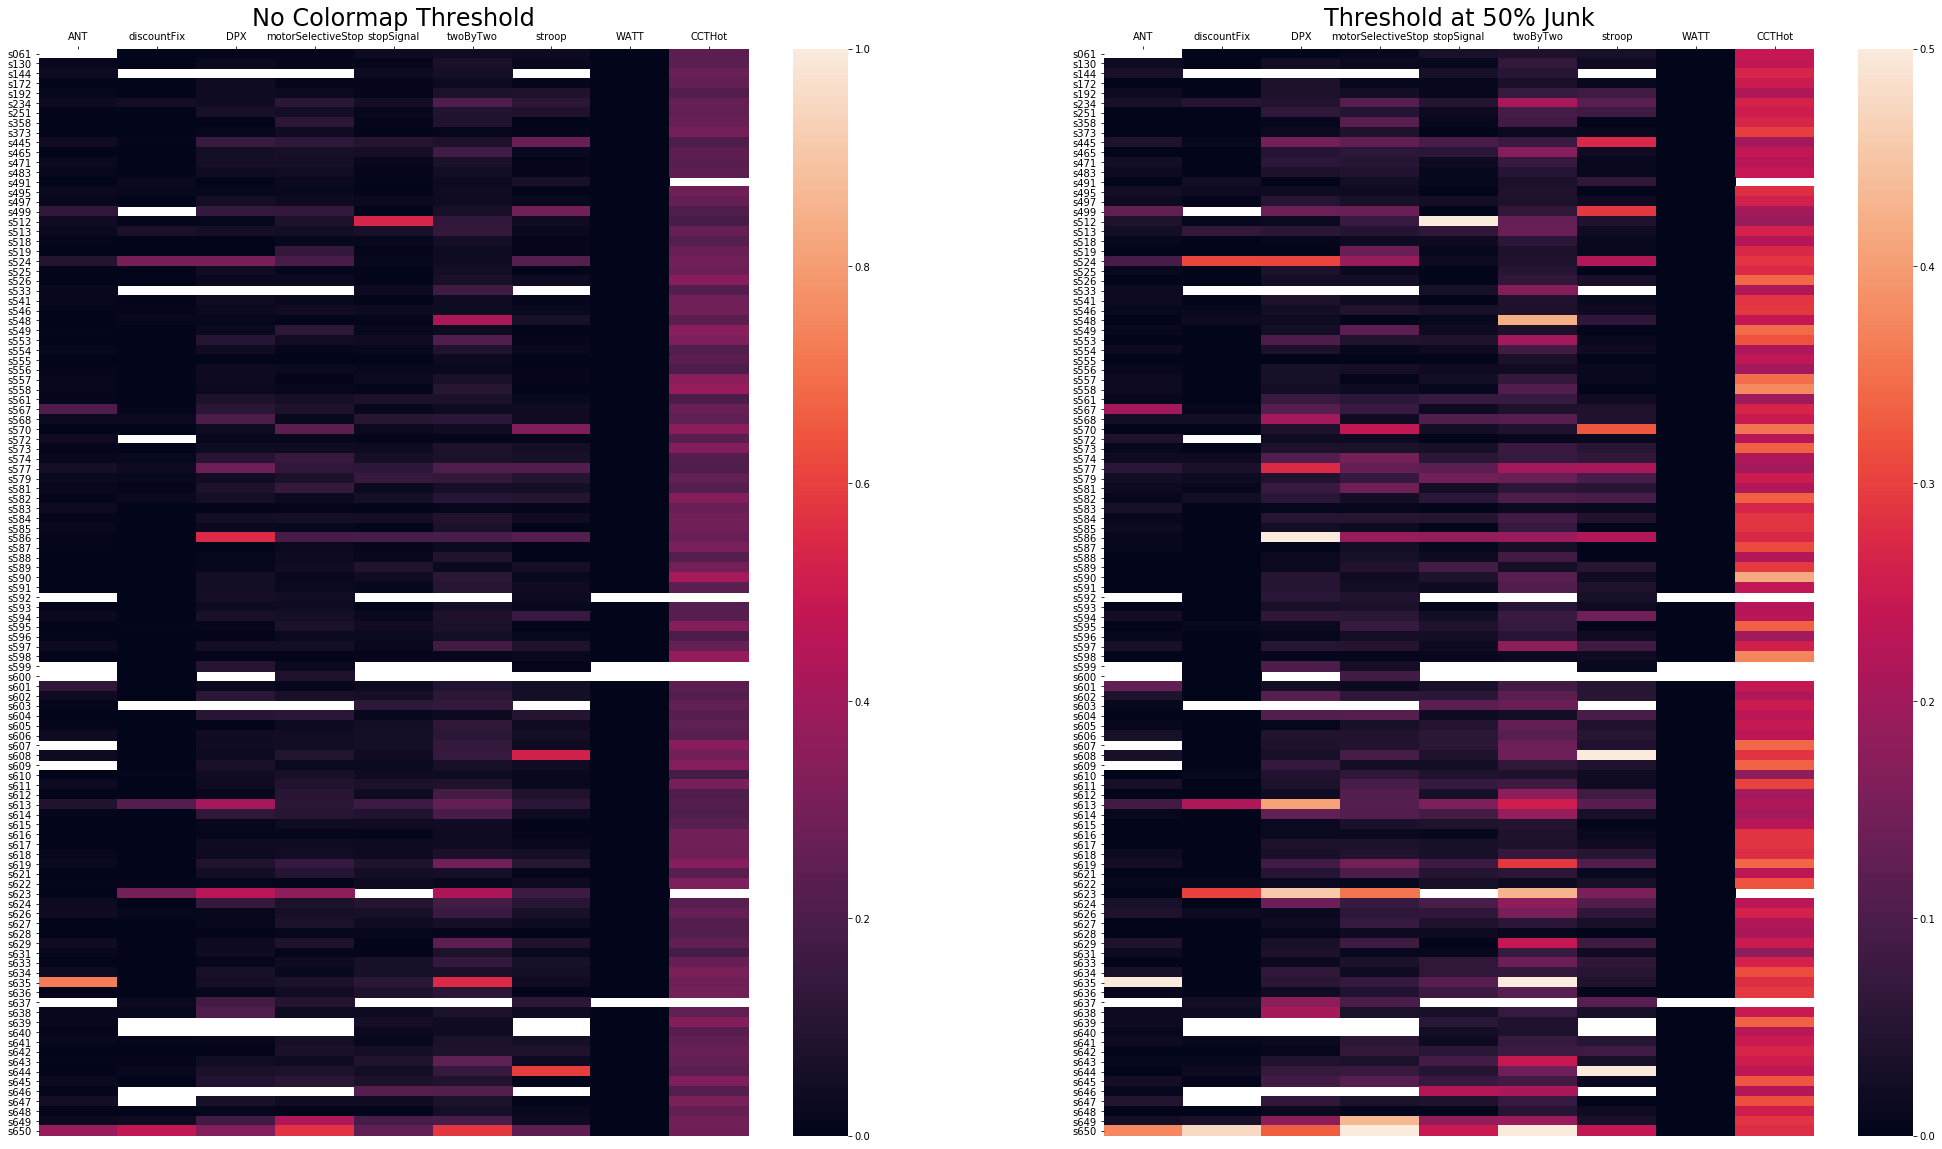

In [14]:
junk_thresh = 0.5

mask = full_junk_percent_df.isnull()
fig, axs = plt.subplots(1,2, figsize=(35,20), sharex=True) 
ax0 = seaborn.heatmap(full_junk_percent_df, ax=axs[0], vmax=1, xticklabels=True, yticklabels=True, mask=mask)
ax0.xaxis.tick_top() # x axis on top
ax0.xaxis.set_label_position('top')
ax0.set_title('No Colormap Threshold', fontsize=24)

ax1 = seaborn.heatmap(full_junk_percent_df, ax=axs[1], vmax=junk_thresh, xticklabels=True, yticklabels=True, mask=mask)
ax1.xaxis.tick_top() # x axis on top
ax1.xaxis.set_label_position('top')
_ = ax1.set_title('Threshold at 50% Junk', fontsize=24)


# Checking Task Acc / Errors

In [15]:
def acc_params(data_df, by_condition=True, condition_col='trial_type'):
    """
    Get accuracy for overall task, along with each condition
    """
    acc_dict={}
    #first get overall accuracy scores
    subjs = []
    accs = []
    bounds = []
    drifts = []
    times = []
    for subj in data_df['worker_id'].unique():
        subj_df = data_df[(data_df['worker_id']==subj)] #subset by worker id
        acc = sum(subj_df['correct']) / len(subj_df['correct'])
        bound, drift, time = ezdiff(subj_df['response_time'], subj_df['correct'])

        subjs.append(subj)
        accs.append(acc)
        bounds.append(bound)
        drifts.append(drift)
        times.append(time)
    acc_dict['task'] = {'subj' : subjs, 'acc': accs, 'bound': bounds, 'drift': drifts, 'time': time}
    
    #if by_condition, then include the condition stats
    if by_condition:
        conditions = data_df.loc[data_df[condition_col].notnull(), condition_col].unique()
        print(conditions)
        for condition in conditions:
            subjs = []
            accs = []
            bounds = []
            drifts = []
            times = []
            for subj in data_df['worker_id'].unique():
                subj_condition_df = data_df[(data_df['worker_id']==subj) & (data_df[condition_col]==condition)] #subset by worker id & condition
                acc = sum(subj_condition_df['correct']) / len(subj_condition_df['correct'])
                if 'stop_success' not in condition:
                    bound, drift, time = ezdiff(subj_condition_df['response_time'], subj_condition_df['correct'])

                subjs.append(subj)
                accs.append(acc)
                bounds.append(bound)
                drifts.append(drift)
                times.append(time)
            acc_dict[condition] = {'subj' : subjs, 'acc': accs, 'bound': bounds, 'drift': drifts, 'time': time}
    return(acc_dict)

In [16]:
def CCTHot_EV_acc(task_df):
    # preprocessing
    task_df['EV_new'] = task_df['gain_amount']*task_df['gain_probability'] + task_df['loss_amount']*task_df['loss_probability']
    task_df['correct'] = np.nan
    # incorrect to draw card with negative EV, end round with positive EV
    task_df.loc[(task_df.action=='draw_card') & (task_df.EV_new < 0), 'correct'] = 0
    task_df.loc[(task_df.action=='end_round') & (task_df.EV_new >= 0), 'correct'] = 0
    # correct to draw card with positive EV, end round with negative EV
    task_df.loc[(task_df.action=='draw_card') & (task_df.EV_new >= 0), 'correct'] = 1
    task_df.loc[(task_df.action=='end_round') & (task_df.EV_new < 0), 'correct'] = 1
    
    acc_dict = {}
    subs = []
    accs = []
    for subj in task_df.worker_id.unique():
        subs.append(subj)
        accs.append(task_df.loc[task_df.worker_id == subj, 'correct'].mean())
    return {'task': {
        'subj': subs,
        'acc': accs
        }}

In [17]:
def discount_acc(task_df):
    # preprocessing
    task_df['correct'] = np.nan
    task_df.loc[task_df.choice=='larger_later', 'correct'] = 1
    task_df.loc[task_df.choice=='smaller_sooner', 'correct'] = 0
    
    acc_dict = {}
    subs = []
    accs = []
    for subj in task_df.worker_id.unique():
        subs.append(subj)
        accs.append(task_df.loc[task_df.worker_id == subj, 'correct'].mean())
    return {'task': {
        'subj': subs,
        'acc': accs
        }}  

In [18]:
def WATT_acc(task_df):
    acc_dict = {}
    subs = []
    accs = []
    for subj in task_df.worker_id.unique():
        sub_df = task_df.loc[task_df.worker_id == subj,].copy()
        sub_df = sub_df.reset_index(drop=True)
        p_idx = sub_df[sub_df.planning==1].index
        f_idx = sub_df[sub_df.trial_id=='feedback'].index
        assert len(p_idx)==len(f_idx)
        moves = f_idx - p_idx
        moves = moves/2
        unnecessary_moves = moves - 3
        subs.append(subj)
        accs.append(np.mean(unnecessary_moves))
    return {'task': {
        'subj': subs,
        'acc': accs
        }}    

In [19]:
def stopSignal_go_acc(task_df):
    acc_dict = {}
    subs = []
    accs = []
    for subj in task_df.worker_id.unique():
        subj_df = task_df[task_df.worker_id == subj]
        go_df = subj_df[(subj_df['condition'] == 'go')]
        subs.append(subj)
        accs.append(go_df.correct.mean())
    return {'task': {
        'subj': subs,
        'acc': accs
        }}

def motorStop_noSignal_acc(task_df):
    acc_dict = {}
    subs = []
    accs = []
    for subj in task_df.worker_id.unique():
        subj_df = task_df[task_df.worker_id == subj]
        no_signal_df = subj_df[subj_df['trial_type'].isin(['go', 'noncrit_nosignal'])]
        subs.append(subj)
        accs.append(no_signal_df.correct.mean())
    return {'task': {
        'subj': subs,
        'acc': accs
        }}

In [20]:
acc_cond_dict = {
    'ANT': 'flanker_type',
    'DPX': 'condition',
    'stop_signal': 'condition',
    'twoByTwo': 'switch_type',
}

acc_funcs = {
    'CCTHot': CCTHot_EV_acc,
    'discountFix': discount_acc,
    'motorSelectiveStop': motorStop_noSignal_acc,
    'WATT': WATT_acc,
    'stopSignal': stopSignal_go_acc
}

full_acc_dict = {}
for task in tasks:
    print(task)
    func = acc_funcs.get(task, lambda x: acc_params(x, condition_col=acc_cond_dict.get(task, 'trial_type')))
    full_acc_dict[task] = func(alldata_dict[task])

ANT
['congruent' 'incongruent']
discountFix
DPX
['AX' 'AY' 'BY' 'BX']
motorSelectiveStop
stopSignal
twoByTwo
['cue_stay' 'task_switch' 'cue_switch']
stroop
['incongruent' 'congruent']
WATT
CCTHot


In [21]:
task_acc_df = None
for key in full_acc_dict.keys():
    task_df = pd.DataFrame.from_dict(full_acc_dict[key]['task'])
    task_df = task_df.set_index('subj')
    task_df.columns = [f'{key}_'+col for col in task_df.columns]
    task_df = task_df[f'{key}_acc']
    if task_acc_df is None:
        task_acc_df = task_df
    else:
        task_acc_df = pd.concat([task_acc_df, task_df], axis=1, sort=False)
        
task_acc_df = task_acc_df.sort_index()

# flip WATT, essentially from errors to acc
task_acc_df['WATT_acc'] = task_acc_df['WATT_acc'].max() - task_acc_df['WATT_acc']

In [22]:
task_acc_df.to_csv('aim1_raw_acc.csv')

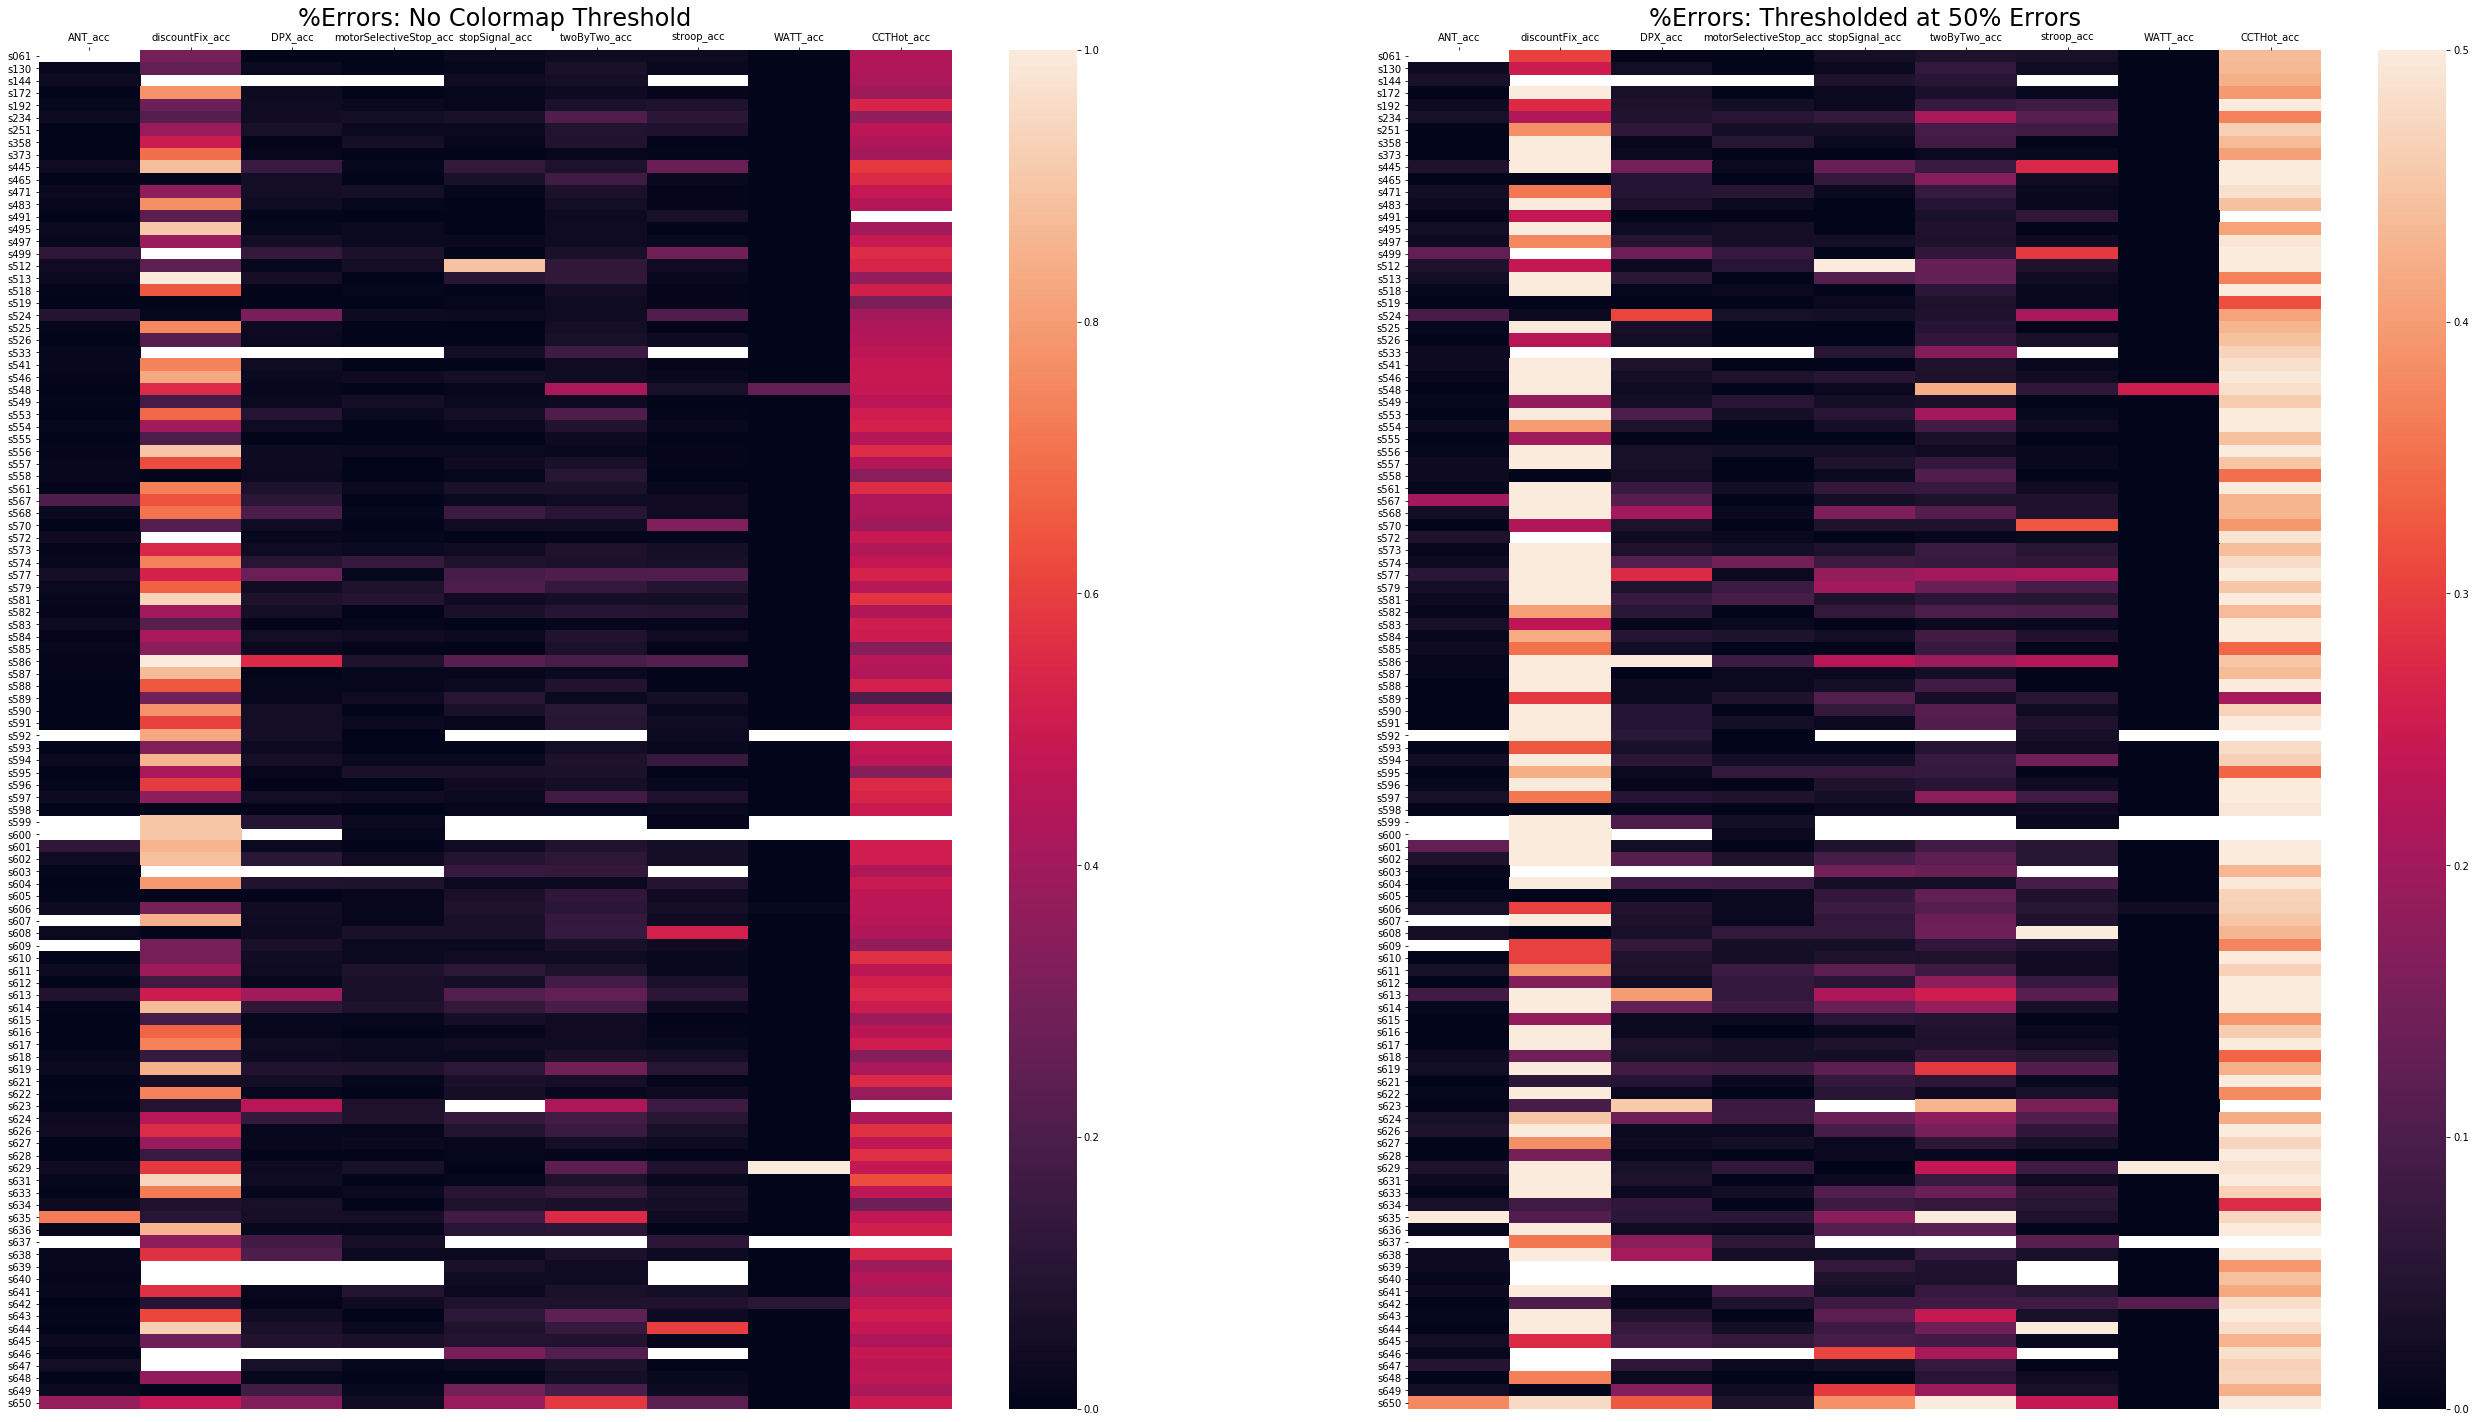

In [23]:
mask = task_acc_df.isnull()
fig, axs = plt.subplots(1,2, figsize=(45,25), sharex=True) 

ax0 = seaborn.heatmap(1 - task_acc_df, vmin=0, vmax=1, ax=axs[0], xticklabels=True, yticklabels=True, mask=mask)
ax0.xaxis.tick_top() # x axis on top
ax0.xaxis.set_label_position('top')
ax0.set_title('%Errors: No Colormap Threshold', fontsize=24)


ax1 = seaborn.heatmap(1 - task_acc_df, vmin=0, vmax=.5, ax=axs[1], xticklabels=True, yticklabels=True, mask=mask)
ax1.xaxis.tick_top() # x axis on top
ax1.xaxis.set_label_position('top')
_ = ax1.set_title('%Errors: Thresholded at 50% Errors', fontsize=24)


In [24]:
task_acc_df.describe()

,ANT_acc,discountFix_acc,DPX_acc,motorSelectiveStop_acc,stopSignal_acc,twoByTwo_acc,stroop_acc,WATT_acc,CCTHot_acc
count,103.000000,101.000000,103.000000,104.000000,105.000000,106.000000,103.000000,106.000000,104.000000
mean,0.971100,0.503024,0.933056,0.972100,0.931556,0.894851,0.937500,1.293719,0.535452
std,0.083090,0.294304,0.093418,0.029588,0.106620,0.099617,0.095303,0.183645,0.067972
min,0.273438,0.000000,0.450000,0.855263,0.106667,0.416667,0.406250,0.000000,0.372152
25%,0.976562,0.258333,0.934375,0.960000,0.920000,0.867708,0.937500,1.226354,0.490341
50%,0.992188,0.500000,0.962500,0.975731,0.960000,0.929167,0.968750,1.345833,0.532047
75%,1.000000,0.750000,0.981250,1.000000,0.986667,0.958333,0.989583,1.407216,0.570982
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.991667,1.000000,1.450000,0.794872


In [25]:
task_acc_df.skew()

ANT_acc                  -6.754784
discountFix_acc           0.082734
DPX_acc                  -3.074395
motorSelectiveStop_acc   -1.174753
stopSignal_acc           -5.046855
twoByTwo_acc             -2.663467
stroop_acc               -3.412328
WATT_acc                 -3.835346
CCTHot_acc                0.708815
dtype: float64

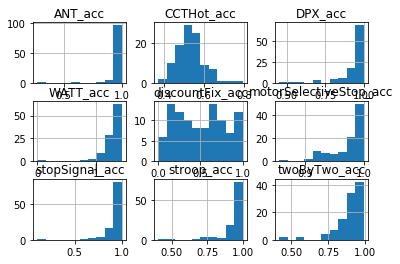

In [26]:
_ = task_acc_df.hist()

# Box-Cox transform

In [27]:
from scipy import stats 


In [28]:
bc_df = task_acc_df.dropna()
for col in bc_df.columns:
    if bc_df[col].min() <= 0:
        bc_df[col] = bc_df[col] - bc_df[col].min() + 0.000000000001
    fitted_data, fitted_lambda = stats.boxcox(bc_df[col])
    bc_df.loc[:,col] = fitted_data

/Users/henrymj/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/henrymj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [29]:
bc_df.skew()

ANT_acc                  -1.343472
discountFix_acc          -0.844588
DPX_acc                  -0.699004
motorSelectiveStop_acc   -0.268909
stopSignal_acc           -0.781161
twoByTwo_acc             -0.428946
stroop_acc               -0.732818
WATT_acc                 -2.768073
CCTHot_acc               -0.011670
dtype: float64

## Z-score

In [30]:
z_acc = (bc_df - bc_df.mean())/bc_df.std(ddof=0)

In [31]:
z_acc.to_csv('aim1_transform-bc_z-score_acc.csv')

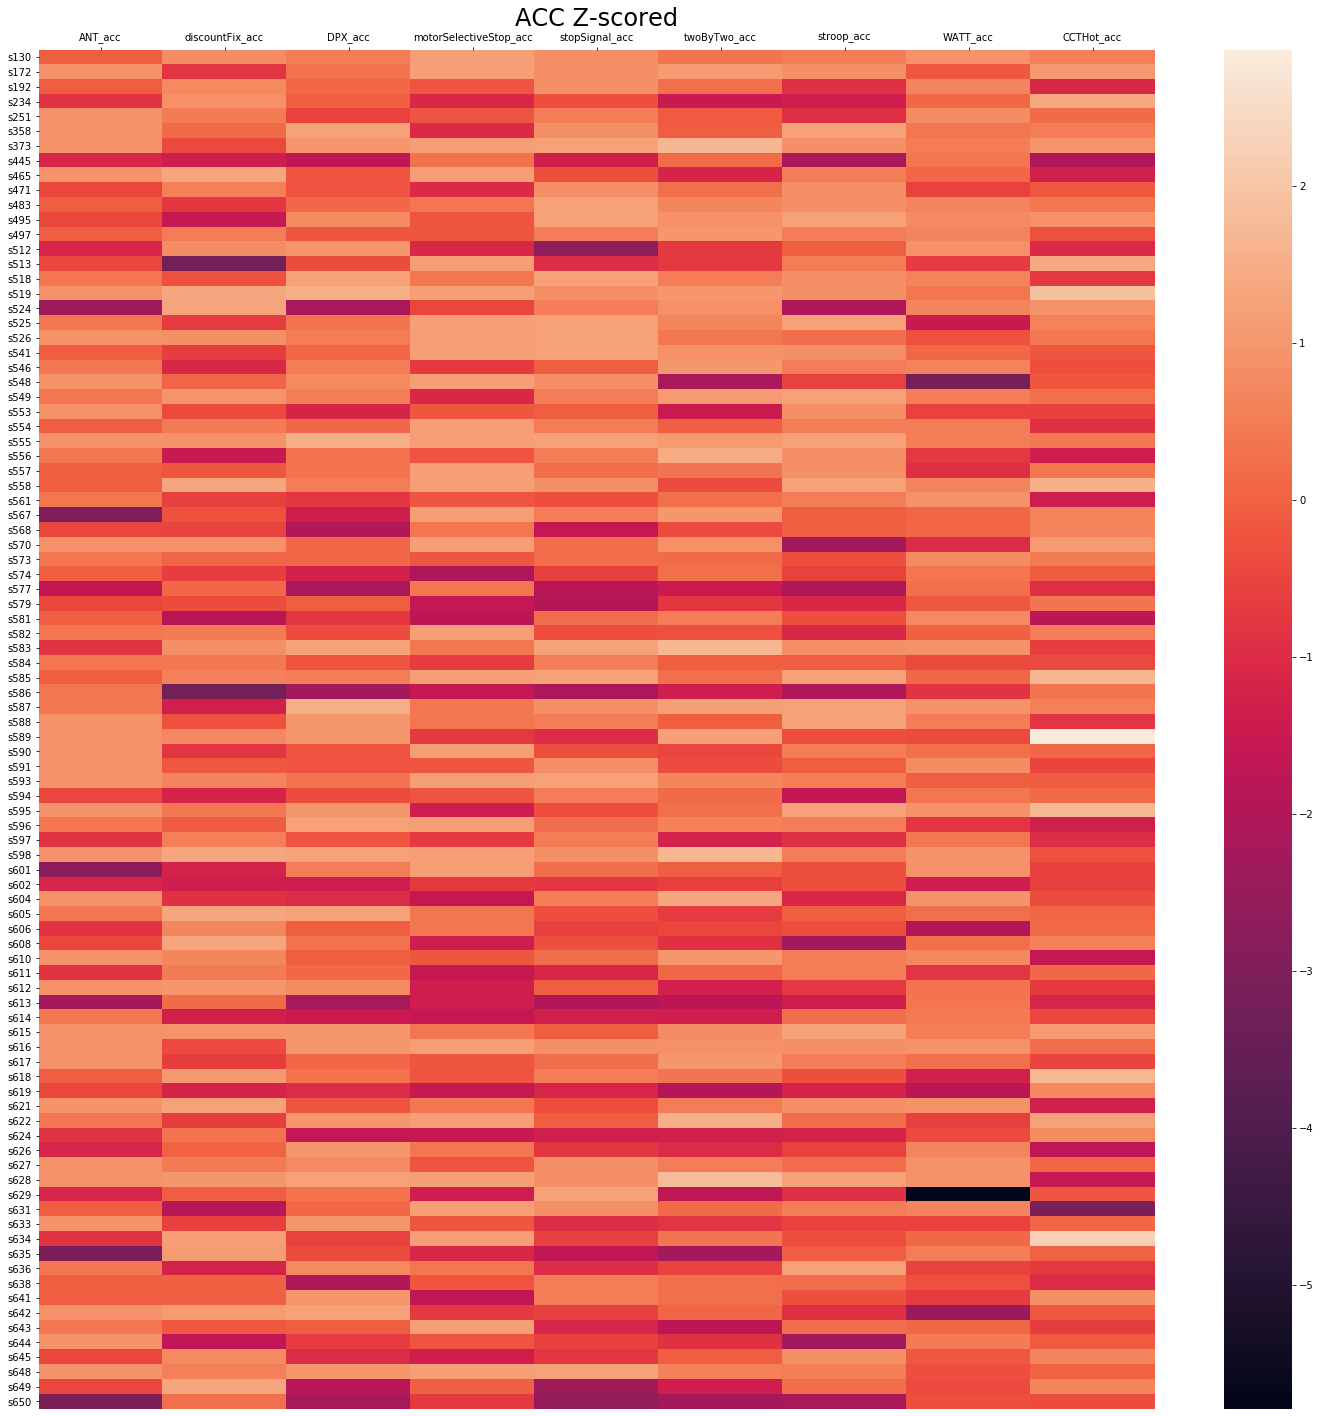

In [32]:
mask = z_acc.isnull()
fig, axs = plt.subplots(1,1, figsize=(25,25), sharex=True) 

ax0 = seaborn.heatmap(z_acc, ax=axs, xticklabels=True, yticklabels=True, mask=mask)
ax0.xaxis.tick_top() # x axis on top
ax0.xaxis.set_label_position('top')
_ = ax0.set_title('ACC Z-scored', fontsize=24)


In [33]:
z_acc.describe()

,ANT_acc,discountFix_acc,DPX_acc,motorSelectiveStop_acc,stopSignal_acc,twoByTwo_acc,stroop_acc,WATT_acc,CCTHot_acc
count,9.200000e+01,9.200000e+01,9.200000e+01,9.200000e+01,9.200000e+01,9.200000e+01,9.200000e+01,9.200000e+01,9.200000e+01
mean,3.330669e-16,-3.970254e-16,-5.792468e-17,3.789239e-16,-1.110223e-16,4.923598e-16,-8.930055e-16,-1.112033e-15,-1.546468e-15
std,1.005479e+00,1.005479e+00,1.005479e+00,1.005479e+00,1.005479e+00,1.005479e+00,1.005479e+00,1.005479e+00,1.005479e+00
min,-3.064347e+00,-3.232545e+00,-2.241548e+00,-2.100631e+00,-2.681120e+00,-2.271784e+00,-2.297475e+00,-5.787128e+00,-3.068759e+00
25%,-4.771021e-01,-6.399396e-01,-4.157865e-01,-6.933149e-01,-5.564765e-01,-7.097197e-01,-5.381844e-01,-4.080944e-01,-6.326504e-01
50%,3.953186e-01,1.411265e-01,1.179116e-01,-2.058827e-01,2.159685e-01,2.046556e-01,2.120481e-01,2.433636e-01,2.550820e-02
75%,9.294786e-01,8.148403e-01,7.944706e-01,1.156456e+00,8.561084e-01,8.131263e-01,8.625042e-01,6.446168e-01,6.246047e-01
max,9.294786e-01,1.330034e+00,1.497760e+00,1.156456e+00,1.219547e+00,1.790276e+00,1.242031e+00,9.163165e-01,2.864266e+00


# PCA on Z-scored ACC

In [34]:
pca = PCA()

In [35]:
_ = pca.fit(z_acc)

In [36]:
pca.explained_variance_ratio_

array([0.35761371, 0.14011307, 0.11581983, 0.09089427, 0.08924369,
       0.06910689, 0.06131889, 0.04313136, 0.0327583 ])

In [37]:
component_scores = pd.DataFrame(pca.transform(z_acc), index=z_acc.index)

In [38]:
component_scores.to_csv('aim1_transform-bc_z-score_PCA_acc.csv')

In [39]:
component_scores.describe()

,0,1,2,3,4,5,6,7,8
count,9.200000e+01,9.200000e+01,9.200000e+01,9.200000e+01,9.200000e+01,9.200000e+01,9.200000e+01,9.200000e+01,9.200000e+01
mean,1.448117e-16,1.779977e-17,-6.275174e-17,-1.206764e-17,-1.206764e-18,-1.659301e-17,2.413528e-18,3.861645e-17,2.413528e-17
std,1.803855e+00,1.129104e+00,1.026564e+00,9.094163e-01,9.011212e-01,7.929671e-01,7.469501e-01,6.264567e-01,5.459528e-01
min,-3.073185e+00,-3.180713e+00,-2.397134e+00,-2.123419e+00,-2.321918e+00,-1.895871e+00,-1.939663e+00,-1.770377e+00,-1.078137e+00
25%,-1.455640e+00,-6.525233e-01,-7.416911e-01,-5.921300e-01,-6.540980e-01,-4.500425e-01,-4.183211e-01,-3.719241e-01,-3.356048e-01
50%,-1.872379e-01,1.310655e-01,-5.966500e-02,-5.449512e-02,-9.586320e-02,3.553284e-02,-1.249619e-03,-1.263394e-02,-7.672029e-02
75%,9.713498e-01,7.322744e-01,4.820310e-01,6.239863e-01,5.852376e-01,3.864910e-01,4.522823e-01,3.149118e-01,3.545087e-01
max,5.276631e+00,3.344684e+00,3.969617e+00,2.199404e+00,3.141081e+00,2.399196e+00,2.431213e+00,1.803062e+00,1.372897e+00


# Get CCTHot and WATT mean stim_timing, nTrials for superficial matrix

In [40]:
def get_stim_timing_num_trials(data_df, task):
    data_df = data_df.copy()
    if task=='WATT':
        end_round_idx = data_df.index[data_df.trial_id=='feedback']
        start_round_idx = data_df.index[data_df.planning==1]
    elif task=='CCTHot':
        end_round_idx = data_df.index[data_df.trial_id=='ITI']
        start_round_idx = [0] + [x + 1 for x in end_round_idx[:-1]]
    assert len(end_round_idx)==len(start_round_idx)

    stim_timings = []
    for start_idx,end_idx in zip(start_round_idx, end_round_idx):
        # Note, this automatically excludes the feedback row
        stim_timings.append(
            data_df.iloc[start_idx:end_idx]\
            ['block_duration'].cumsum().iloc[-1]
        )
    return (np.mean(stim_timings), len(stim_timings))

In [41]:
pd.DataFrame(alldata_dict['CCTHot'].groupby('worker_id').apply(get_stim_timing_num_trials, task='CCTHot').tolist(), columns=['stim_timing', 'num_trials']).mean()

stim_timing    5.122460 
num_trials     81.028846
dtype: float64

In [42]:
pd.DataFrame(alldata_dict['WATT'].groupby('worker_id').apply(get_stim_timing_num_trials, task='WATT').tolist(), columns=['stim_timing', 'num_trials']).mean()

stim_timing    6949.251998
num_trials     45.349057  
dtype: float64